In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

import time

import pandas as pd
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
from datetime import date

import jax
import jax.numpy as jnp

import numpyro
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist

We'll illustrate the model by fitting an autoregressive dynamic factor analysis (ARDFA) model to time series of COVID-19 hospitaliations in each US state and the national level.

In [2]:
dat = pd.read_csv('hosp_dat.csv')
dat

,location,date,inc,population,pop100k,inc_rate,rm_inc_rate,log_rm_inc_rate,sqrt_rm_inc_rate,fourthrt_rm_inc_rate
0,01,2020-10-01,106,4903185,49.03185,2.182255,2.182255,0.780359,1.477246,1.215420
1,01,2020-10-02,120,4903185,49.03185,2.467784,2.325019,0.843728,1.524801,1.234828
2,01,2020-10-03,98,4903185,49.03185,2.019096,2.223045,0.798878,1.490988,1.221060
3,01,2020-10-04,97,4903185,49.03185,1.998701,2.166959,0.773325,1.472059,1.213285
4,01,2020-10-05,126,4903185,49.03185,2.590153,2.251598,0.811640,1.500532,1.224962
...,...,...,...,...,...,...,...,...,...,...
34981,US,2022-08-13,5174,332875137,3328.75137,1.554637,1.817885,0.597673,1.348289,1.161159
34982,US,2022-08-14,5135,332875137,3328.75137,1.542921,1.806726,0.591517,1.344145,1.159373
34983,US,2022-08-15,6011,332875137,3328.75137,1.806083,1.785225,0.579545,1.336123,1.155908
34984,US,2022-08-16,6377,332875137,3328.75137,1.916034,1.776900,0.574870,1.333004,1.154558


The model expects the data to be provided in an array with shape `(n_timesteps, n_locations)`. We'll work here with the log of the 7-day rolling mean of the incidence rate per 100,000 population, which is comparable across locations and has fairly stable variance over time.

In [3]:
# Get data into an array of values with shape (n_timesteps, n_locations)
# we'll work with the log of the 7-day rolling mean of the incidence rate per 100,000 population
dat_array = dat[['location', 'date', 'log_rm_inc_rate']] \
    .pivot(index='date', columns='location', values='log_rm_inc_rate') \
    .values
dat_array.shape

(686, 51)

We now define the model and run estimation.

In [4]:
def ardfa(y, p=1, n_factors=1, intercept_by_series=False,
          loadings_constraint='positive'):
    """
    Auto-regressive dynamic factor analysis model
    
    Parameters
    ----------
    y: array with shape (n_timesteps, n_series)
        Observed data. For example, if 5 locations then there are 5 columns
    p: integer
        Order of autoregressive processes for latent factors
    n_factors: integer
        Number of latent factors
    interept_by_series: boolean
        If True, a separate 
    loadings_constraint: string
        Constraints on factor loadings. Either 'sum_to_1' or 'positive'
    """
    # number of time steps and series (e.g. locations)
    n_timesteps, n_series = y.shape
    
    # intercept for observation model, series-specific if requested
    # arranged as row vector for later broadcasting across timesteps
    if intercept_by_series:
        intercept_shape = (1, n_series)
    else:
        intercept_shape = (1,)
    intercept = numpyro.sample("intercept", dist.Normal(0, 1),
                               sample_shape=intercept_shape)
    
    # ar coefficients, shared across latent factors
    phi = numpyro.sample("phi", dist.Normal(0, 1), sample_shape=(1, p))
    
    # standard deviation of innovations in AR process for latent factors
    sigma_factors = numpyro.sample("sigma_factors", dist.HalfNormal(1))
    
    # factor loadings, shape (n_series, n_factors)
    if loadings_constraint == 'positive':
        factor_loadings = numpyro.sample(
            "factor_loadings",
            dist.Exponential(jnp.ones((n_series, n_factors))))
    elif loadings_constraint == 'sum_to_1':
        factor_loadings = numpyro.sample(
            "factor_loadings",
            dist.Dirichlet(jnp.ones((n_factors,))),
            sample_shape=(n_series,))
    
    # initial values for factor loadings; corresponds to p time steps before time 0
    factors_init = numpyro.sample("factors_init", dist.Normal(0, 1), sample_shape=(p, n_factors))
    
    # get latent factors from AR(p) process
    def transition(factors_prev, _):
        """
        transition function for use with scan
        
        Parameters
        ----------
        factors_prev: array of shape (p, n_factors)
            latent factor values for the p time steps before time t
        _: ignored, corresponds to integer time step value
        
        Returns
        -------
        factors: array of shape (p, n_factors)
            updated latent factor values for the p time steps ending at time t
        factors_t: array of shape (n_factors,)
            latent factor values at time t
        """
        # factors_prev shape is (p, n_factors)
        m_t = jnp.matmul(phi, factors_prev)
        factors_t = numpyro.sample("factors", dist.Normal(m_t, sigma_factors))
        carry = jnp.concatenate((factors_prev[1:, :], factors_t), axis=0)
        return carry, factors_t[0, :]
    
    # scan over time steps; latent factors shape is (n_timepoints, n_factors)
    timesteps = jnp.arange(n_timesteps)
    _, latent_factors = scan(transition, factors_init, timesteps)
    
    # standard deviation of observation noise
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfNormal(1))
    
    # observation model for y
    numpyro.sample(
        'y',
        dist.Normal(loc=intercept + jnp.matmul(latent_factors, jnp.transpose(factor_loadings)),
                    scale=sigma_obs),
        obs=y, sample_shape = y.shape)


def run_inference(model, y, p, n_factors, intercept_by_series, loadings_constraint,
                  num_warmup, num_samples, num_chains, rng_key):
    start = time.time()
    sampler = numpyro.infer.NUTS(model)
    mcmc = numpyro.infer.MCMC(
        sampler,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, y=y, p=p, n_factors=n_factors,
             intercept_by_series=intercept_by_series, loadings_constraint=loadings_constraint)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


num_warmup = 1000
num_samples = 1000
num_chains = 1
rng_key = jax.random.PRNGKey(0)

samples = run_inference(model=ardfa, y=dat_array,
                        p=2, n_factors=4, intercept_by_series=False,
                        loadings_constraint='positive',
                        num_warmup=num_warmup, num_samples=num_samples,
                        num_chains=num_chains, rng_key=rng_key)

sample: 100%|██████████| 2000/2000 [06:12<00:00,  5.37it/s, 1023 steps of size 1.16e-03. acc. prob=0.72]



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
 factor_loadings[0,0]      1.05      0.11      1.08      0.81      1.17      4.72      1.39
 factor_loadings[0,1]      0.17      0.04      0.16      0.12      0.23      4.57      1.50
 factor_loadings[0,2]      0.52      0.09      0.53      0.37      0.67      3.69      1.65
 factor_loadings[0,3]      1.51      0.04      1.51      1.45      1.58     10.80      1.08
 factor_loadings[1,0]      0.03      0.02      0.02      0.00      0.05     11.10      1.18
 factor_loadings[1,1]      0.36      0.08      0.35      0.21      0.50      3.60      1.89
 factor_loadings[1,2]      0.71      0.15      0.68      0.49      0.96      3.04      1.95
 factor_loadings[1,3]      1.26      0.03      1.27      1.22      1.30     12.66      1.00
 factor_loadings[2,0]      0.55      0.05      0.56      0.45      0.61      5.26      1.35
 factor_loadings[2,1]      0.68      0.14      0.66      0.47      0.91      3.

Below is a plot of the 25th and 75th percentile estimates of a mean over time for each location, based on the ARDFA(2,4) model, i.e., 4 latent factors that each follow an AR(2) process. With such limited flexibility, the model is not able to follow variability in the data for each location, but it is generally consistent with the trends in each location. One could imagine increasing the number of latent factors used or adding an additional location-specific AR process to this mean using a hierarchical structure. 

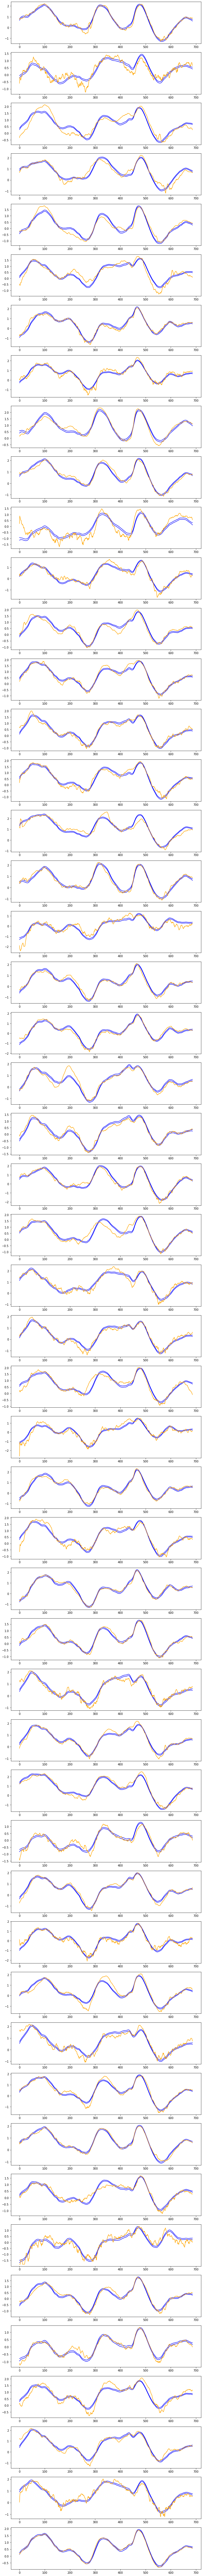

In [5]:
num_locs = dat_array.shape[1]

means_by_loc = samples['intercept'][..., jnp.newaxis] + jnp.matmul(
    samples['factors'][:, :, 0, :],
    jnp.transpose(samples['factor_loadings'], axes=(0,2,1)))

t=jnp.linspace(0, dat_array.shape[0], dat_array.shape[0])
fig, ax = plt.subplots(num_locs, 1, figsize = (10, num_locs * 2.5), squeeze=False)
for i in range(num_locs):
    ax[i, 0].plot(t,
                  jnp.quantile(means_by_loc[..., i], q=0.025, axis=0),
                  color='blue')
    ax[i, 0].plot(t,
                  jnp.quantile(means_by_loc[..., i], q=0.975, axis=0),
                  color='blue')
    ax[i, 0].plot(t, dat_array[:, i], color='orange')

plt.tight_layout()

Below is a plot of the latent factor values that were sampled.

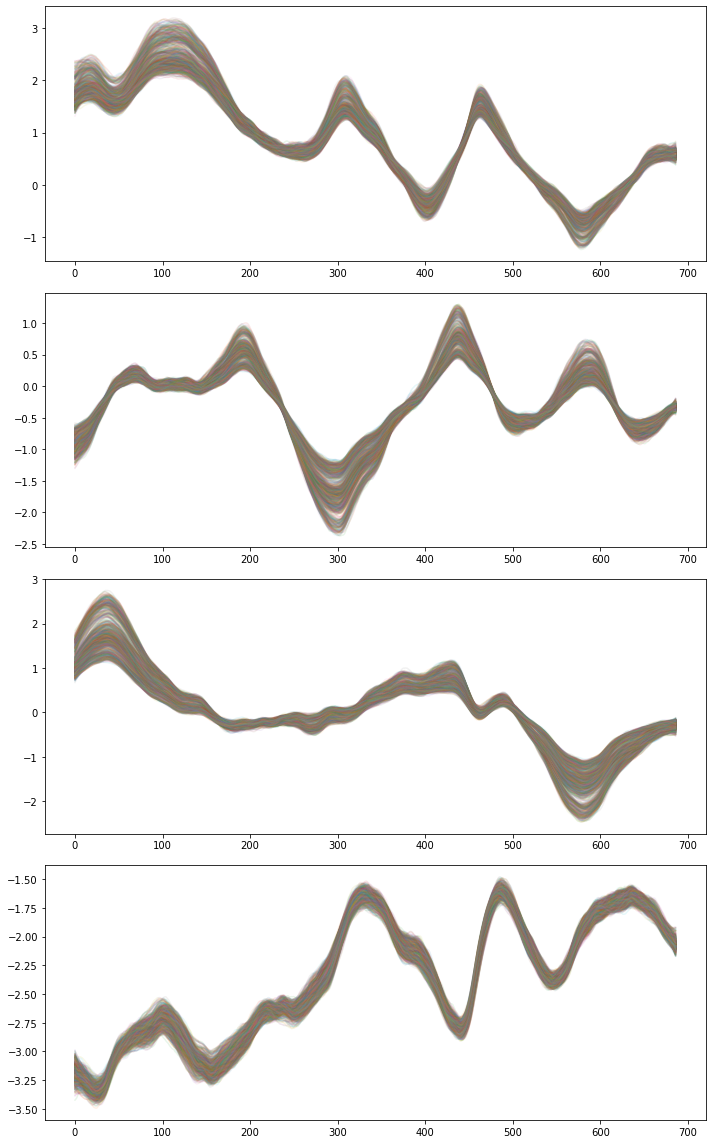

In [6]:
factor_samples = samples['factors'][:, :, 0, :]
t=jnp.linspace(0, factor_samples.shape[1], factor_samples.shape[1])
fig, ax = plt.subplots(4, 1, figsize = (10, 4 * 4), squeeze=False)
for i in range(4):
    for j in range(1000):
        ax[i, 0].plot(t, factor_samples[j, :, i], alpha = 0.1)

plt.tight_layout()